# Pedestrian Collision Analysis
## Dimithra Ratnayake

In [212]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import shap
import scipy.stats as stats
from scipy.stats import poisson
from scipy.stats import ks_2samp
from sklearn.cluster import DBSCAN
from geopy.distance import great_circle
from shapely.geometry import MultiPoint
from sklearn import tree

# Set some Pandas options
pd.set_option('notebook_repr_html', False)
pd.set_option('max_columns', 30)
pd.set_option('max_rows', 20)
#max rows and columns are important not to crash the notebook

In [2]:
all_data = pd.read_excel("Data/Excel_sheets/Collisions2.xlsx", sheet_name = 'All_Collisions_1')
all_data

       OBJECTID                              ADDRESS  \
0         28948         E CONE BLVD / N O HENRY BLVD   
1         28949             N CHURCH ST / CHARLES ST   
2         28950  JOSEPH M BRYAN BLVD / NEW GARDEN RD   
3         28951              W MARKET ST / N TATE ST   
4         28952           PHILLIPS AV / N ENGLISH ST   
5         28953              SUMMIT AV / PHILLIPS AV   
6         28954       E BESSEMER AV / YANCEYVILLE ST   
7         28955      BATTLEGROUND AV / W BESSEMER AV   
8         28956             E BESSEMER AV / SYKES AV   
9         28957         E LINDSAY ST / E WENDOVER AV   
...         ...                                  ...   
51994    100175          E GATE CITY BLVD / MACON ST   
51995    100164            E WENDOVER AV / ELWELL AV   
51996    100165                               I 40 W   
51997    100174          E WENDOVER AV / N CHURCH ST   
51998    100168                 US 29 N / TEXTILE DR   
51999    100170                           FLEMIN

### Data Cleaning

Since the data had errors because of spelling errors, time errors, punctuation errors and missing data, the data set is cleaned extensively to only retain valuable data

In [3]:
all_data.isnull().sum()

OBJECTID                0
ADDRESS                22
ACCIDENT_CAUSE         96
COLLISION_DESC          4
WEATHER                26
LIGHT_CONDITIONS       26
ROAD_CLASS             24
TRAFFIC_CONTROL        45
PEDESTRIAN_REL        900
HIT_RUN              4861
                    ...  
X                       0
Y                       0
BIPED               50859
SEVERITY                0
SEVERITY_CD             0
A_INJURIES            132
B_INJURIES            132
C_INJURIES            132
CASE_NUM                0
DEPARTMENT          40778
Length: 27, dtype: int64

In [4]:
all_data.COLLISION_DESC.value_counts()

ANGLE                                                   11094
REAR END, SLOW OR STOP                                  10907
SIDESWIPE, SAME DIRECTION                                3925
Rear End, Slow Or Stop                                   2714
Angle                                                    2601
RAN OFF ROAD - RIGHT                                     2473
BACKING UP                                               2405
FIXED OBJECT*                                            1556
RAN OFF ROAD - LEFT                                      1483
LEFT TURN, SAME ROADWAY                                  1183
                                                        ...  
ANGLE, OTHER COLLISION WITH VEHICLE*                        1
REAR END TURN                                               1
RAN OFF ROAD -LEFT/FIXED OBJECT                             1
RAN OFF ROAD - LEFT/ANGLE                                   1
OTHER IMPROPER PASSING                                      1
RAN OFF 

In [5]:
all_data.PEDESTRIAN_REL.value_counts()

NO        50003
YES        1074
N            20
<Null>        4
-             1
no            1
MO            1
Name: PEDESTRIAN_REL, dtype: int64

In [6]:
all_data.loc[all_data["COLLISION_DESC"].str.contains("PEDESTRIAN", na=False) == False, "PEDESTRIAN_REL"] = "NO"
all_data.loc[all_data["COLLISION_DESC"].str.contains("PEDESTRIAN", na=False), "PEDESTRIAN_REL"] = "YES"
all_data.PEDESTRIAN_REL.value_counts()

NO     51230
YES      774
Name: PEDESTRIAN_REL, dtype: int64

In [7]:
all_data.BIPED.value_counts()

P         921
B         210
<Null>     12
p           2
Name: BIPED, dtype: int64

In [8]:
targets = ['PEDESTRIAN', 'CYCLIST']
#all_data.loc[all_data["COLLISION_DESC"].apply(lambda sentence: any(word in sentence for word in targets)) == False, 'BIPED'] = 'N'
all_data.loc[(~all_data["COLLISION_DESC"].str.contains("PEDESTRIAN", na=False)) &
             (~all_data["COLLISION_DESC"].str.contains("CYCLIST", na=False)), 'BIPED'] = 'M'
all_data.loc[all_data["COLLISION_DESC"].str.contains("PEDESTRIAN", na=False), 'BIPED'] = 'P'
all_data.loc[all_data["COLLISION_DESC"].str.contains("CYCLIST", na=False), 'BIPED'] = 'B'
#all_all_data.loc[all_data["COLLISION_DESC"].str.contains("PEDESTRIAN", na=False) == False, "PEDESTRIAN_REL"] = "NO"data.loc[all_data["COLLISION_DESC"].str.contains("CYCLIST", na=False), "PE_CY_MO"] = "CY"
all_data.BIPED.value_counts()

M    51111
P      774
B      119
Name: BIPED, dtype: int64

In [9]:
all_data.LIGHT_CONDITIONS.value_counts()

DAYLIGHT                                                29937
Daylight                                                 6806
DARK-LIGHTED ROADWAY                                     6299
DARK - LIGHTED ROADWAY                                   2370
Dark - Lighted Roadway                                   2069
DARK-ROADWAY NOT LIGHTED                                 1181
DUSK                                                     1123
DARK - ROADWAY NOT LIGHTED                                494
Dark - Roadway Not Lighted                                486
DAWN                                                      403
                                                        ...  
SNOW                                                        1
DARK-RAODWAY NOT LIGHTED                                    1
RAIN                                                        1
OTHER*\r                                                    1
DARK - LIGHTED ROADWAR                                      1
DARK - R

In [10]:
all_data.LIGHT_CONDITIONS.value_counts()

DAYLIGHT                                                29937
Daylight                                                 6806
DARK-LIGHTED ROADWAY                                     6299
DARK - LIGHTED ROADWAY                                   2370
Dark - Lighted Roadway                                   2069
DARK-ROADWAY NOT LIGHTED                                 1181
DUSK                                                     1123
DARK - ROADWAY NOT LIGHTED                                494
Dark - Roadway Not Lighted                                486
DAWN                                                      403
                                                        ...  
SNOW                                                        1
DARK-RAODWAY NOT LIGHTED                                    1
RAIN                                                        1
OTHER*\r                                                    1
DARK - LIGHTED ROADWAR                                      1
DARK - R

In [11]:
all_data.loc[all_data['LIGHT_CONDITIONS'].isin(['Daylight', 'DAYLGHT']), 'LIGHT_CONDITIONS'] = 'DAYLIGHT'
all_data.loc[all_data['LIGHT_CONDITIONS'].isin(['DARK - LIGHTED ROADWAY', 'Dark - Lighted Roadway', 
                                               'DARK-LIGHTED ORADWAY', 'DARL-LIGHTED ROADWAY', 'DARK - LIGHTED ROADWAY\r',
                                               'DARK - LIGHTED ROADAY', 'DARK - LIGHTED ROADWAR',
                                               'DARK - LIGHT ROADWAY', 'DARK - LIGHTED WAY',
                                               'DARK LIGHTED ROADWAY', 'DARK- LIGHTED ROADWAY']),'LIGHT_CONDITIONS'] = 'DARK-LIGHTED ROADWAY'
all_data.loc[all_data['LIGHT_CONDITIONS'].isin(['Dark - Roadway Not Lighted', 'DARK - ROADWAY NOT LIGHTED\r', 
                                               'DARK-RAODWAY NOT LIGHTED', 'DARK-ROADWAY NOT LIGHTEDDARK - ROADWAY NOT LIGHTED\r',
                                               'DARK-ROADWAY NOT LIGHTED', 'DARK ROADWAY NOT LIGHTED',
                                               'DARK ROADWAY-NOT LIGHTED']),
            'LIGHT_CONDITIONS'] = 'DARK - ROADWAY NOT LIGHTED'
all_data.loc[all_data['LIGHT_CONDITIONS'].isin(['DARK - UNKNOWN LIGHTING', 'DARK UNKNOWN LIGHTING', 
                                               'DARK - UNKNOWN LIGHTING\r', 'Dark - Unknown Lighting']), 
            'LIGHT_CONDITIONS'] = 'DARK-UNKNOWN LIGHTING'
all_data.loc[all_data['LIGHT_CONDITIONS'].isin(['Dusk']), 'LIGHT_CONDITIONS'] = 'DUSK'
all_data.loc[all_data['LIGHT_CONDITIONS'].isin(['Dawn']), 'LIGHT_CONDITIONS'] = 'DAWN'
all_data.loc[all_data['LIGHT_CONDITIONS'].isin(['Unknown']), 'LIGHT_CONDITIONS'] = 'UNKNOWN'
all_data.loc[all_data['LIGHT_CONDITIONS'].isin(['OTHER*', 'Other', 'OTHER*\r']), 'LIGHT_CONDITIONS'] = 'OTHER'

all_data.LIGHT_CONDITIONS.value_counts()

DAYLIGHT                      36744
DARK-LIGHTED ROADWAY          10773
DARK - ROADWAY NOT LIGHTED     2172
DUSK                           1387
DAWN                            523
UNKNOWN                         194
DARK-UNKNOWN LIGHTING           154
OTHER                            23
CLOUDY                            4
BLOWING SAND, DIRT, SNOW          1
SNOW                              1
RAIN                              1
SEVERE CROSSWINDS                 1
Name: LIGHT_CONDITIONS, dtype: int64

In [12]:
all_data.WEATHER.value_counts()

CLEAR                                 31066
Clear                                  6375
CLOUDY                                 6122
RAIN                                   4484
Cloudy                                 1364
Rain                                   1291
SNOW                                    484
Snow                                    197
SLEET,HAIL,FREEZING RAIN/DRIZZLE        187
SLEET, HAIL, FREEZING RAIN/DRIZZLE      160
                                      ...  
RAIN/ SNOW                                1
CLOUDY / RAIN                             1
RAIN\r                                    1
OTHER*\r                                  1
FOG, SMOG, SMOKE\r\n\r                    1
CEAR                                      1
RAIN/CLOUDY\nRAIN/CLOUDY                  1
-                                         1
CLEAR\nCLEAR\nCLEAR\nCLEAR                1
RAIN/ SEVERE CROSSWINDS                   1
Name: WEATHER, Length: 34, dtype: int64

In [13]:
all_data.loc[all_data['WEATHER'].isin(['Clear', 'CEAR', 'CLEAR\nCLEAR\nCLEAR\nCLEAR']), 'WEATHER'] = 'CLEAR'
all_data.loc[all_data['WEATHER'].isin(['Cloudy']), 'WEATHER'] = 'CLOUDY'
all_data.loc[all_data['WEATHER'].isin(['Rain', 'RAIN\r']), 'WEATHER'] = 'RAIN'
all_data.loc[all_data['WEATHER'].isin(['Snow', 'SNOW\r']), 'WEATHER'] = 'SNOW'
all_data.loc[all_data['WEATHER'].isin(['SLEET, HAIL, FREEZING RAIN/DRIZZLE',
                                      'SLEET. HAIL. FREEZING RAIN/DRIZZLE',
                                      'Sleet, Hail, Freezing Rain/Drizzle']), 'WEATHER'] = 'SLEET,HAIL,FREEZING RAIN/DRIZZLE'
all_data.loc[all_data['WEATHER'].isin(['FOG,SMOG,SMOKE', 'Fog, Smog, Smoke'
                                       , 'FOG, SMOG, SMOKE\r\n\r']), 'WEATHER'] = 'FOG, SMOG, SMOKE'
all_data.loc[all_data['WEATHER'].isin(['BLOWING SAND,DIRT,SNOW', 'Blowing Sand, Dirt, Snow']), 'WEATHER'] = 'BLOWING SAND, DIRT, SNOW'
all_data.loc[all_data['WEATHER'].isin(['OTHER*\r', 'Other', 'OTHER*']), 'WEATHER'] = 'OTHER'
all_data.loc[all_data['WEATHER'].isin(['CLOUDY / RAIN', 'RAIN/CLOUDY\nRAIN/CLOUDY']), 'WEATHER'] = 'RAIN / CLOUDY'
all_data.loc[all_data['WEATHER'].isin(['-']), 'WEATHER'] = 'UNKNOWN'
all_data.WEATHER.value_counts()

CLEAR                               37443
CLOUDY                               7486
RAIN                                 5776
SNOW                                  683
SLEET,HAIL,FREEZING RAIN/DRIZZLE      403
FOG, SMOG, SMOKE                      117
OTHER                                  51
BLOWING SAND, DIRT, SNOW                6
RAIN / CLOUDY                           6
SEVERE CROSSWINDS                       3
RAIN/ SNOW                              1
CLOUDLY / CLEAR                         1
UNKNOWN                                 1
RAIN/ SEVERE CROSSWINDS                 1
Name: WEATHER, dtype: int64

In [14]:
all_data.TRAFFIC_CONTROL.value_counts()

NO CONTROL PRESENT             26098
STOP AND GO SIGNAL             10645
No Control Present              5225
STOP SIGN                       3760
Stop And Go Signal              2936
Stop Sign                       1005
---                              553
FLASHING STOP AND GO SIGNAL      514
YIELD SIGN                       467
Flashing Stop And Go Signal      146
                               ...  
STOP AND GO SGNAL                  1
NONE                               1
STOP AND GO  SIGNAL                1
NO COLTROL PRESENT                 1
NO CONROL PRESENT                  1
NO CONTROL PRESEMT                 1
NO CONTROL PRSSENT                 1
CONTROL NOT PRESENT                1
--                                 1
NO CONTRL PRESENT                  1
Name: TRAFFIC_CONTROL, Length: 47, dtype: int64

In [15]:
all_data.loc[all_data['TRAFFIC_CONTROL'].isin(['Stop Sign']), 'TRAFFIC_CONTROL'] = 'STOP SIGN'
all_data.loc[all_data['TRAFFIC_CONTROL'].isin(['No Control Present', 'NO CNTROL PRESENT', 'NO OCNTROL PRESENT',
                                               'NO CONROL PRESENT', 'NO CONTRL PRESENT', 'CONTROL NOT PRESENT',
                                              'NO CONTROL PRESEMT', 'NO COLTROL PRESENT', 'NO CONTROL PRSENT',
                                              'NO CONTROL PRSSENT', 'NO CONTOL PRESENT', 'NONE']), 
             'TRAFFIC_CONTROL'] = 'NO CONTROL PRESENT'
all_data.loc[all_data['TRAFFIC_CONTROL'].isin(['Stop And Go Signal', 'STOP AND GO SGNAL',
                                              'STOP AND GO  SIGNAL']), 'TRAFFIC_CONTROL'] = 'STOP AND GO SIGNAL'
all_data.loc[all_data['TRAFFIC_CONTROL'].isin(['Yield Sign']), 'TRAFFIC_CONTROL'] = 'YIELD SIGN'
all_data.loc[all_data['TRAFFIC_CONTROL'].isin(['Flashing Stop And Go Signal']), 
             'TRAFFIC_CONTROL'] = 'FLASHING STOP AND GO SIGNAL'
all_data.loc[all_data['TRAFFIC_CONTROL'].isin(['Flashing Signal With Stop Sign']), 
             'TRAFFIC_CONTROL'] = 'FLASHING SIGNAL WITH STOP SIGN'
all_data.loc[all_data['TRAFFIC_CONTROL'].isin(['Rr Flasher']), 'TRAFFIC_CONTROL'] = 'RR FLASHER'
all_data.loc[all_data['TRAFFIC_CONTROL'].isin(['OTHER*', 'Other']), 'TRAFFIC_CONTROL'] = 'OTHER'
all_data.loc[all_data['TRAFFIC_CONTROL'].isin(['School Zone Signs']), 'TRAFFIC_CONTROL'] = 'SCHOOL ZONE SIGNS'
all_data.loc[all_data['TRAFFIC_CONTROL'].isin(['Flashing Signal Without Stop Sign', 'FLASHING SIGNAL WITHOUT STOP SIGN\r']), 
             'TRAFFIC_CONTROL'] = 'FLASHING SIGNAL WITHOUT STOP SIGN'
all_data.loc[all_data['TRAFFIC_CONTROL'].isin(['Warning Sign']), 'TRAFFIC_CONTROL'] = 'WARNING SIGN'
all_data.loc[all_data['TRAFFIC_CONTROL'].isin(['Human Control']), 'TRAFFIC_CONTROL'] = 'HUMAN CONTROL'
all_data.loc[all_data['TRAFFIC_CONTROL'].isin(['---', '--']), 'TRAFFIC_CONTROL'] = 'UNKNOWN'
all_data.loc[all_data['TRAFFIC_CONTROL'].isin(['Rr Gate And Flasher']), 'TRAFFIC_CONTROL'] = 'RR GATE AND FLASHER'
all_data.loc[all_data['TRAFFIC_CONTROL'].isin(['Double Yellow Line, No Passing Zone', 
                                               'DOUBLE YELLOW LINE, NO PASSING ZONE\r']),
             'TRAFFIC_CONTROL'] = 'DOUBLE YELLOW LINE, NO PASSING ZONE'
#all_data.loc[all_data['TRAFFIC_CONTROL'].isin(['STOP AND GO SIGNAL']), 'TRAFFIC_CONTROL'] = 'STOP SIGN'
#all_data.loc[all_data['TRAFFIC_CONTROL'].isin(['FLASHING STOP AND GO SIGNAL']), 
#             'TRAFFIC_CONTROL'] = 'FLASHING SIGNAL WITH STOP SIGN'
all_data.TRAFFIC_CONTROL.value_counts()

NO CONTROL PRESENT                     31339
STOP AND GO SIGNAL                     13583
STOP SIGN                               4765
FLASHING STOP AND GO SIGNAL              660
YIELD SIGN                               594
UNKNOWN                                  554
OTHER                                    111
DOUBLE YELLOW LINE, NO PASSING ZONE       99
WARNING SIGN                              85
FLASHING SIGNAL WITH STOP SIGN            54
HUMAN CONTROL                             39
RR GATE AND FLASHER                       34
FLASHING SIGNAL WITHOUT STOP SIGN         25
SCHOOL ZONE SIGNS                          7
RR FLASHER                                 7
RR CROSSBUCKS ONLY                         3
Name: TRAFFIC_CONTROL, dtype: int64

In [16]:
all_data.HIT_RUN.value_counts()

NO     23087
N      13972
No      4621
Y       2221
YES     2150
Yes     1092
Name: HIT_RUN, dtype: int64

In [17]:
all_data.loc[all_data['HIT_RUN'].isin(['N', 'No']), 'HIT_RUN'] = 'NO'
all_data.loc[all_data['HIT_RUN'].isin(['Y', 'Yes']), 'HIT_RUN'] = 'NO'
all_data.HIT_RUN.value_counts()

NO     44993
YES     2150
Name: HIT_RUN, dtype: int64

In [18]:
all_data.SEVERITY.value_counts()

O No Injury                          31884
C Type Injury (Possible)             16286
B Type Injury (Evident)               2052
Unknown                                800
B Type Injury (Suspected Minor)        671
Fatality                               132
A Type Injury (Disabling)              128
A Type Injury (Suspected Serious)       49
C Type Injury (Possible)\r               1
UNKNOWN                                  1
Name: SEVERITY, dtype: int64

In [19]:
all_data.loc[all_data['SEVERITY'].isin(['C Type Injury (Possible)\r']), 'SEVERITY'] = 'C Type Injury (Possible)'
all_data.loc[all_data['SEVERITY'].isin(['Unknown']), 'SEVERITY'] = 'UNKNOWN'
all_data.SEVERITY.value_counts()

O No Injury                          31884
C Type Injury (Possible)             16287
B Type Injury (Evident)               2052
UNKNOWN                                801
B Type Injury (Suspected Minor)        671
Fatality                               132
A Type Injury (Disabling)              128
A Type Injury (Suspected Serious)       49
Name: SEVERITY, dtype: int64

Extracting date from case number as it containes the accurate date

In [20]:
all_data.ACCIDENT_DATE.value_counts()
#all_data['TIME'] = all_data.ACCIDENT_DATE.dt.time
#time is not available in this location for fatalities data
all_data['CASE_NUM'] = all_data.CASE_NUM.astype(str)
all_data['DATE'] = pd.to_datetime(all_data.CASE_NUM.str[:8])
all_data['YEAR'] = all_data.DATE.dt.year
all_data['MONTH'] = all_data.DATE.dt.month
all_data['DAY'] = all_data.DATE.dt.day_name()

all_data.DAY.value_counts()

Friday       8958
Wednesday    7868
Thursday     7821
Tuesday      7703
Monday       7607
Saturday     6758
Sunday       5289
Name: DAY, dtype: int64

In [21]:
all_data.shape
all_data['ACCIDENT_TIME'].isnull().sum()

898

In [22]:

all_data = all_data.dropna(subset=['ACCIDENT_TIME'], axis=0)
all_data.shape

(51106, 31)

In [23]:
all_data['DATE'] = (all_data['DATE']).astype(str)
all_data['ACCIDENT_TIME'] = (all_data['ACCIDENT_TIME']).astype(str)
all_data['ACCIDENT_TIME'].dtypes

C:\Users\dimit\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\dimit\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


dtype('O')

In [24]:
all_data['DATE'].head()

0    2014-01-01
1    2014-01-01
2    2014-01-01
3    2014-01-01
4    2014-01-01
Name: DATE, dtype: object

In [25]:
all_data['ACCIDENT_TIME'].dtypes
#all_data['ACCIDENT_TIME'] = pd.to_datetime(all_data['ACCIDENT_TIME'])
#all_data['DATE_TIME'] = df.apply(lambda r : pd.datetime.combine(all_data['DATE'],all_data['ACCIDENT_TIME']),1)
#all_data['DATE_TIME'] = pd.to_datetime(all_data['DATE'] + ' ' + all_data['ACCIDENT_TIME'])
all_data['DATE_TIME'] = pd.to_datetime(all_data['DATE'] + ' ' + all_data['ACCIDENT_TIME'])

C:\Users\dimit\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [26]:
all_data['DATE_TIME'].dtypes

dtype('<M8[ns]')

Create a categorical variable for time.

This would enable classify accidents into specific classes that just the accident time

In [27]:
#all_data.loc[all_data['ACCIDENT_TIME'].between_time('6:30:00','10:00:00'), 'DAY_TIME'] = 'Morning'
all_data.loc[(all_data['ACCIDENT_TIME'] > '06:30:00') & (all_data['ACCIDENT_TIME'] <= '10:00:00'), 'DAY_TIME'] = 'Morning'
all_data.loc[(all_data['ACCIDENT_TIME'] > '10:00:00') & (all_data['ACCIDENT_TIME'] <= '15:30:00'), 'DAY_TIME'] = 'Day'
all_data.loc[(all_data['ACCIDENT_TIME'] > '15:30:00') & (all_data['ACCIDENT_TIME'] <= '18:30:00'), 'DAY_TIME'] = 'Evening'
all_data.loc[(all_data['ACCIDENT_TIME'] > '18:30:00') & (all_data['ACCIDENT_TIME'] <= '22:00:00'), 'DAY_TIME'] = 'Night'
all_data.loc[(all_data['ACCIDENT_TIME'] > '22:00:00') | (all_data['ACCIDENT_TIME'] <= '06:30:00'), 'DAY_TIME'] = 'Late Night'

C:\Users\dimit\Anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\dimit\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [28]:
all_data['DAY_TIME'].value_counts()

Day           17230
Evening       12687
Morning        7612
Night          7221
Late Night     6356
Name: DAY_TIME, dtype: int64

Combining fatality with severity.

This enables supervised learning with classification dependent variable as "SEVERITY_CD".

In [29]:
#all_data.loc[all_data['FATALITY'].isin(['Unknown']), 'SEVERITY'] = 'UNKNOWN'
all_data.loc[(all_data['FATALITY'] == 1 ), 'SEVERITY'] = 'Fatal'
all_data.loc[all_data['FATALITY'] == 1 , 'SEVERITY_CD'] = 1
all_data['SEVERITY'].value_counts()
all_data['SEVERITY_CD'].value_counts()

5    31334
4    15999
3     2676
6      788
2      177
1      132
Name: SEVERITY_CD, dtype: int64

In [30]:
ped_data = all_data[all_data.BIPED == 'P']
cyc_data = all_data[all_data.BIPED == 'B']
motor_data = all_data[all_data.BIPED == 'M']

In [31]:
motor_data.shape

(50227, 33)

### Statistics

In [32]:
dsts=all_data.groupby(['BIPED','YEAR', 'MONTH']).OBJECTID.count().to_frame(name='COUNT').reset_index()
dsts

    BIPED  YEAR  MONTH  COUNT
0       B  2014      1      1
1       B  2014      2      1
2       B  2014      5      3
3       B  2014      6      6
4       B  2014      7      5
5       B  2014      8      2
6       B  2014      9      3
7       B  2014     10      2
8       B  2014     11      3
9       B  2014     12      1
..    ...   ...    ...    ...
156     P  2018      3     11
157     P  2018      4     12
158     P  2018      5     12
159     P  2018      6     15
160     P  2018      7     10
161     P  2018      8     15
162     P  2018      9     16
163     P  2018     10     17
164     P  2018     11     15
165     P  2018     12      9

[166 rows x 4 columns]

In [33]:
print('Monthly Vehicle collision skewness:',dsts[dsts.BIPED=='M'].COUNT.skew())
print('Monthly Pedestrian collision skewness:',dsts[dsts.BIPED=='P'].COUNT.skew())
print('Monthly Cyclist collision skewness:',dsts[dsts.BIPED=='B'].COUNT.skew())

Monthly Vehicle collision skewness: -2.1848081154142664
Monthly Pedestrian collision skewness: -0.018590146164800432
Monthly Cyclist collision skewness: 0.45857163682676805


In [34]:
print('Monthly Vehicle collision kurtosis:',dsts[dsts.BIPED=='M'].COUNT.kurt())
print('Monthly Pedestrian collision kurtosis:',dsts[dsts.BIPED=='P'].COUNT.kurt())
print('Monthly Cyclist collision kurtosis:',dsts[dsts.BIPED=='B'].COUNT.kurt())

Monthly Vehicle collision kurtosis: 10.493919530422925
Monthly Pedestrian collision kurtosis: 0.4099505626716864
Monthly Cyclist collision kurtosis: -0.7396477155118295


In [35]:
dsts1 = dsts.groupby(['BIPED','COUNT']).COUNT.count().to_frame(name='FREQ').reset_index()
dsts1

   BIPED  COUNT  FREQ
0      B      1    15
1      B      2     9
2      B      3     9
3      B      4    10
4      B      5     2
5      B      6     1
6      M      5     1
7      M    584     1
8      M    601     1
9      M    611     1
..   ...    ...   ...
71     P     12    10
72     P     13     4
73     P     14     2
74     P     15     5
75     P     16     4
76     P     17     3
77     P     18     2
78     P     19     4
79     P     20     1
80     P     22     1

[81 rows x 3 columns]

Text(0.5,0,'COLLISIONS')

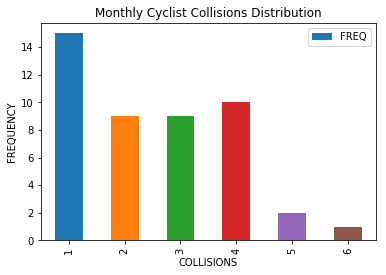

In [36]:
dsts1[dsts1.BIPED == 'B'].plot.bar(x='COUNT', y='FREQ')
plt.title('Monthly Cyclist Collisions Distribution')
plt.ylabel('FREQUENCY')
plt.xlabel('COLLISIONS')

Text(0.5,0,'COLLISIONS')

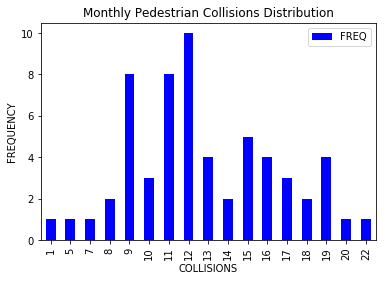

In [37]:
dsts1[dsts1.BIPED == 'P'].plot.bar(x='COUNT', y='FREQ', color='blue')
plt.title('Monthly Pedestrian Collisions Distribution')
plt.ylabel('FREQUENCY')
plt.xlabel('COLLISIONS')

Text(0.5,0,'COLLISIONS')

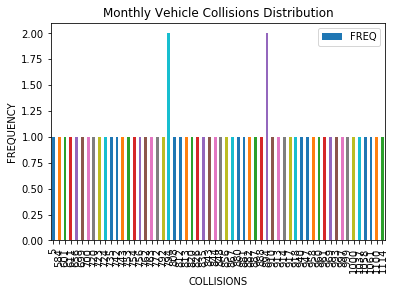

In [38]:
dsts1[dsts1.BIPED == 'M'].plot.bar(x='COUNT', y='FREQ')
plt.title('Monthly Vehicle Collisions Distribution')
plt.ylabel('FREQUENCY')
plt.xlabel('COLLISIONS')

In [39]:
dsts2 = dsts.groupby(['BIPED']).COUNT.mean().to_frame(name='AVG_COLLISIONS').reset_index()
dsts2

  BIPED  AVG_COLLISIONS
0     B        2.521739
1     M      837.116667
2     P       12.716667

In [40]:
dsts3 = dsts.groupby(['BIPED']).COUNT.std().to_frame(name='STD_COLLISIONS').reset_index()
dsts3

  BIPED  STD_COLLISIONS
0     B        1.378230
1     M      162.976664
2     P        3.940626

### Analysis

In [41]:
df=all_data.groupby(['BIPED','YEAR']).OBJECTID.count().to_frame(name='COUNT').reset_index()
type(df)

pandas.core.frame.DataFrame

In [42]:
df

   BIPED  YEAR  COUNT
0      B  2014     27
1      B  2015     38
2      B  2016     16
3      B  2017     26
4      B  2018      9
5      M  2014   8706
6      M  2015   9740
7      M  2016   9818
8      M  2017  10873
9      M  2018  11090
10     P  2014    163
11     P  2015    171
12     P  2016    129
13     P  2017    145
14     P  2018    155

In [43]:
list(df)

['BIPED', 'YEAR', 'COUNT']

Text(0,0.5,'Collisions')

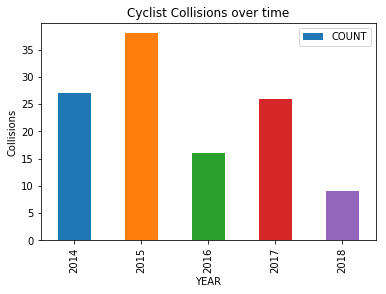

In [44]:
df[df.BIPED == 'B'].plot.bar(x='YEAR', y='COUNT')
plt.title('Cyclist Collisions over time')
plt.ylabel('Collisions')

Conducting correlation analysis with the variables.

In [45]:
np.corrcoef(df[df.BIPED == 'B'].YEAR, df[df.BIPED == 'B'].COUNT)[0,1]

-0.6823801608434201

Text(0,0.5,'Collisions')

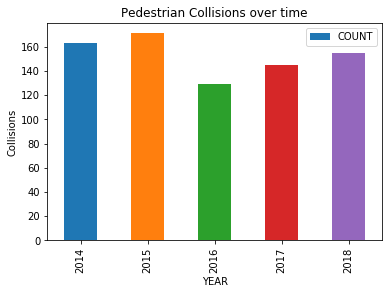

In [46]:
df[df.BIPED == 'P'].plot.bar(x='YEAR', y='COUNT')
plt.title('Pedestrian Collisions over time')
plt.ylabel('Collisions')

In [47]:
np.corrcoef(df[df.BIPED == 'P'].YEAR, df[df.BIPED == 'P'].COUNT)[0,1]

-0.40656162364774223

Text(0,0.5,'Collisions')

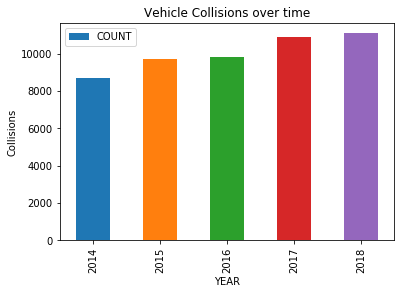

In [48]:
df[df.BIPED == 'M'].plot.bar(x='YEAR', y='COUNT')
plt.title('Vehicle Collisions over time')
plt.ylabel('Collisions')

In [49]:
np.corrcoef(df[df.BIPED == 'M'].YEAR, df[df.BIPED == 'M'].COUNT)[0,1]

0.9681470856838059

In [50]:
df_p = df.pivot(index='BIPED', columns='YEAR')
df_p

      COUNT                          
YEAR   2014  2015  2016   2017   2018
BIPED                                
B        27    38    16     26      9
M      8706  9740  9818  10873  11090
P       163   171   129    145    155

In [51]:
stats.chi2_contingency(df_p)


(42.2777298721486,
 1.2010251494109519e-06,
 8,
 array([[   20.19207138,    22.58216256,    22.61393965,    25.06758502,
            25.54424138],
        [ 8742.99283841,  9777.88171643,  9791.64092279, 10854.04821352,
         11060.43630885],
        [  132.8150902 ,   148.536121  ,   148.74513756,   164.88420146,
           168.01944977]]))

##### Weather

In [52]:
df1=all_data.groupby(['BIPED','WEATHER']).OBJECTID.count().to_frame(name='COUNT').reset_index()
df1

   BIPED                           WEATHER  COUNT
0      B                             CLEAR     96
1      B                            CLOUDY     14
2      B                              RAIN      6
3      M          BLOWING SAND, DIRT, SNOW      6
4      M                             CLEAR  36196
5      M                   CLOUDLY / CLEAR      1
6      M                            CLOUDY   7183
7      M                  FOG, SMOG, SMOKE    116
8      M                             OTHER     48
9      M                              RAIN   5557
..   ...                               ...    ...
13     M  SLEET,HAIL,FREEZING RAIN/DRIZZLE    401
14     M                              SNOW    682
15     M                           UNKNOWN      1
16     P                             CLEAR    584
17     P                            CLOUDY     97
18     P                             OTHER      1
19     P                              RAIN     77
20     P           RAIN/ SEVERE CROSSWINDS      1


Text(0,0.5,'Collisions')

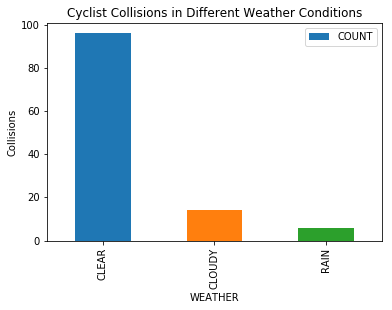

In [53]:
df1[df1.BIPED == 'B'].plot.bar(x='WEATHER', y='COUNT')
plt.title('Cyclist Collisions in Different Weather Conditions')
plt.ylabel('Collisions')

Text(0,0.5,'Collisions')

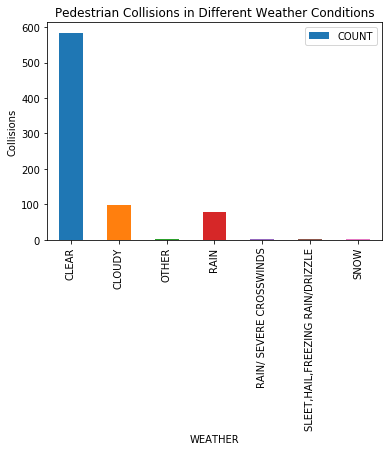

In [54]:
df1[df1.BIPED == 'P'].plot.bar(x='WEATHER', y='COUNT')
plt.title('Pedestrian Collisions in Different Weather Conditions')
plt.ylabel('Collisions')

Text(0,0.5,'Collisions')

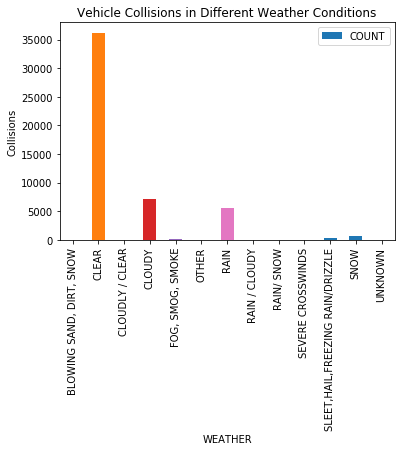

In [55]:
df1[df1.BIPED == 'M'].plot.bar(x='WEATHER', y='COUNT')
plt.title('Vehicle Collisions in Different Weather Conditions')
plt.ylabel('Collisions')

In [56]:
df1_p = df1.pivot(index='BIPED', columns='WEATHER')
df1_p=df1_p.fillna(0)
df1_p

                           COUNT                                   \
WEATHER BLOWING SAND, DIRT, SNOW    CLEAR CLOUDLY / CLEAR  CLOUDY   
BIPED                                                               
B                            0.0     96.0             0.0    14.0   
M                            6.0  36196.0             1.0  7183.0   
P                            0.0    584.0             0.0    97.0   

                                                                              \
WEATHER FOG, SMOG, SMOKE OTHER    RAIN RAIN / CLOUDY RAIN/ SEVERE CROSSWINDS   
BIPED                                                                          
B                    0.0   0.0     6.0           0.0                     0.0   
M                  116.0  48.0  5557.0           6.0                     0.0   
P                    0.0   1.0    77.0           0.0                     1.0   

                                                                              \
WEATHER RAIN/ SNOW SEVER

In [57]:
stats.chi2_contingency(df1_p)

(92.05078530834882,
 2.594703510552193e-09,
 26,
 array([[1.36256852e-02, 8.37434612e+01, 2.27094753e-03, 1.65642913e+01,
         2.63429914e-01, 1.11276429e-01, 1.28081441e+01, 1.36256852e-02,
         2.27094753e-03, 2.27094753e-03, 6.81284260e-03, 9.15191856e-01,
         1.55105717e+00, 2.27094753e-03],
        [5.89675020e+00, 3.62414267e+04, 9.82791699e-01, 7.16848265e+03,
         1.14003837e+02, 4.81567933e+01, 5.54294518e+03, 5.89675020e+00,
         9.82791699e-01, 9.82791699e-01, 2.94837510e+00, 3.96065055e+02,
         6.71246731e+02, 9.82791699e-01],
        [8.96241190e-02, 5.50829836e+02, 1.49373532e-02, 1.08953054e+02,
         1.73273297e+00, 7.31930305e-01, 8.42466719e+01, 8.96241190e-02,
         1.49373532e-02, 1.49373532e-02, 4.48120595e-02, 6.01975333e+00,
         1.02022122e+01, 1.49373532e-02]]))

In [58]:
df11 = df1[df1['WEATHER'].isin(['RAIN', 'CLOUDY', 'CLEAR'])]
df11_p = df11.pivot(index='BIPED', columns='WEATHER')
stats.chi2_contingency(df11_p)

(9.311926207535167,
 0.05375854227400708,
 4,
 array([[8.58786589e+01, 1.69866292e+01, 1.31347119e+01],
        [3.62289487e+04, 7.16601454e+03, 5.54103674e+03],
        [5.61172616e+02, 1.10998836e+02, 8.58285485e+01]]))

##### Light Condition

In [59]:
df2=all_data.groupby(['BIPED','LIGHT_CONDITIONS']).OBJECTID.count().to_frame(name='COUNT').reset_index()
df2

   BIPED            LIGHT_CONDITIONS  COUNT
0      B  DARK - ROADWAY NOT LIGHTED      7
1      B        DARK-LIGHTED ROADWAY     27
2      B                        DAWN      2
3      B                    DAYLIGHT     78
4      B                        DUSK      2
5      M    BLOWING SAND, DIRT, SNOW      1
6      M                      CLOUDY      4
7      M  DARK - ROADWAY NOT LIGHTED   2075
8      M        DARK-LIGHTED ROADWAY  10374
9      M       DARK-UNKNOWN LIGHTING    145
..   ...                         ...    ...
16     M                        SNOW      1
17     M                     UNKNOWN    188
18     P  DARK - ROADWAY NOT LIGHTED     67
19     P        DARK-LIGHTED ROADWAY    251
20     P       DARK-UNKNOWN LIGHTING      6
21     P                        DAWN     11
22     P                    DAYLIGHT    405
23     P                        DUSK     18
24     P                       OTHER      4
25     P                     UNKNOWN      1

[26 rows x 3 columns]

Text(0,0.5,'Collisions')

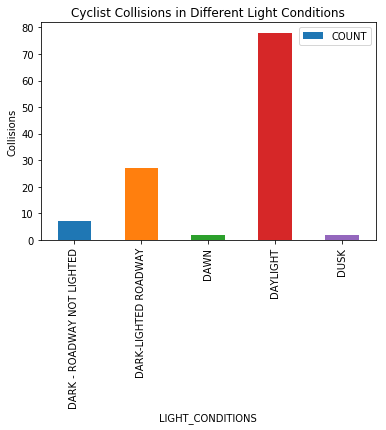

In [60]:
df2[df2.BIPED == 'B'].plot.bar(x='LIGHT_CONDITIONS', y='COUNT')
plt.title('Cyclist Collisions in Different Light Conditions')
plt.ylabel('Collisions')

Text(0,0.5,'Collisions')

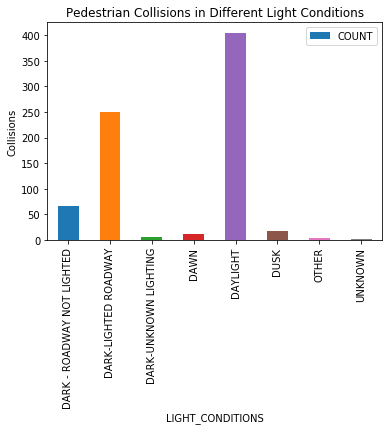

In [61]:
df2[df2.BIPED == 'P'].plot.bar(x='LIGHT_CONDITIONS', y='COUNT')
plt.title('Pedestrian Collisions in Different Light Conditions')
plt.ylabel('Collisions')

Text(0,0.5,'Collisions')

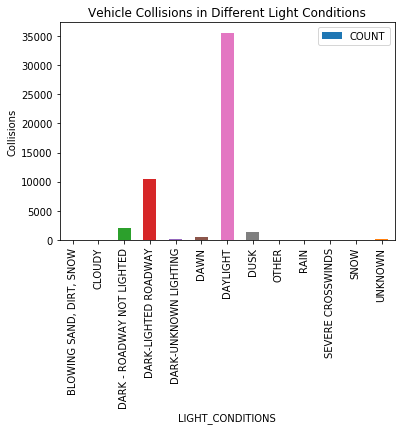

In [62]:
df2[df2.BIPED == 'M'].plot.bar(x='LIGHT_CONDITIONS', y='COUNT')
plt.title('Vehicle Collisions in Different Light Conditions')
plt.ylabel('Collisions')

In [63]:
df2_p = df2.pivot(index='BIPED', columns='LIGHT_CONDITIONS')
df2_p=df2_p.fillna(0)
df1_p

                           COUNT                                   \
WEATHER BLOWING SAND, DIRT, SNOW    CLEAR CLOUDLY / CLEAR  CLOUDY   
BIPED                                                               
B                            0.0     96.0             0.0    14.0   
M                            6.0  36196.0             1.0  7183.0   
P                            0.0    584.0             0.0    97.0   

                                                                              \
WEATHER FOG, SMOG, SMOKE OTHER    RAIN RAIN / CLOUDY RAIN/ SEVERE CROSSWINDS   
BIPED                                                                          
B                    0.0   0.0     6.0           0.0                     0.0   
M                  116.0  48.0  5557.0           6.0                     0.0   
P                    0.0   1.0    77.0           0.0                     1.0   

                                                                              \
WEATHER RAIN/ SNOW SEVER

In [64]:
stats.chi2_contingency(df2_p)

(180.1332072552536,
 6.909477169946608e-26,
 24,
 array([[2.27094753e-03, 9.08379013e-03, 4.88026625e+00, 2.41901331e+01,
         3.42913078e-01, 1.17862177e+00, 8.18176977e+01, 3.09303054e+00,
         4.99608457e-02, 2.27094753e-03, 2.27094753e-03, 2.27094753e-03,
         4.29209084e-01],
        [9.82791699e-01, 3.93116680e+00, 2.11201936e+03, 1.04686972e+04,
         1.48401547e+02, 5.10068892e+02, 3.54080193e+04, 1.33856229e+03,
         2.16214174e+01, 9.82791699e-01, 9.82791699e-01, 9.82791699e-01,
         1.85747631e+02],
        [1.49373532e-02, 5.97494127e-02, 3.21003720e+01, 1.59112686e+02,
         2.25554033e+00, 7.75248630e+00, 5.38162960e+02, 2.03446750e+01,
         3.28621770e-01, 1.49373532e-02, 1.49373532e-02, 1.49373532e-02,
         2.82315975e+00]]))

In [65]:
df21 = df2[df2['LIGHT_CONDITIONS'].isin(['DAYLIGHT', 'DARK-LIGHTED ROADWAY', 'DARK - ROADWAY NOT LIGHTED',
                                        'DAWN', 'DUSK'])]
df21_p = df21.pivot(index='BIPED', columns='LIGHT_CONDITIONS')
stats.chi2_contingency(df21_p)

(130.89902106226356,
 1.841877605332501e-24,
 8,
 array([[4.91587458e+00, 2.43666338e+01, 1.18722146e+00, 8.24146717e+01,
         3.11559850e+00],
        [2.11221570e+03, 1.04696704e+04, 5.10116308e+02, 3.54113109e+04,
         1.33868673e+03],
        [3.18684283e+01, 1.57963005e+02, 7.69647012e+00, 5.34274423e+02,
         2.01976730e+01]]))

##### Traffic Control

In [66]:
df3=all_data.groupby(['BIPED','TRAFFIC_CONTROL']).OBJECTID.count().to_frame(name='COUNT').reset_index()
df3

   BIPED                      TRAFFIC_CONTROL  COUNT
0      B  DOUBLE YELLOW LINE, NO PASSING ZONE      1
1      B          FLASHING STOP AND GO SIGNAL      2
2      B                   NO CONTROL PRESENT     50
3      B                   STOP AND GO SIGNAL     34
4      B                            STOP SIGN     25
5      B                              UNKNOWN      2
6      B                         WARNING SIGN      1
7      B                           YIELD SIGN      1
8      M  DOUBLE YELLOW LINE, NO PASSING ZONE     96
9      M       FLASHING SIGNAL WITH STOP SIGN     54
..   ...                                  ...    ...
24     P  DOUBLE YELLOW LINE, NO PASSING ZONE      1
25     P          FLASHING STOP AND GO SIGNAL      4
26     P                        HUMAN CONTROL      2
27     P                   NO CONTROL PRESENT    537
28     P                                OTHER      3
29     P                   STOP AND GO SIGNAL    144
30     P                            STOP SIGN 

Text(0,0.5,'Collisions')

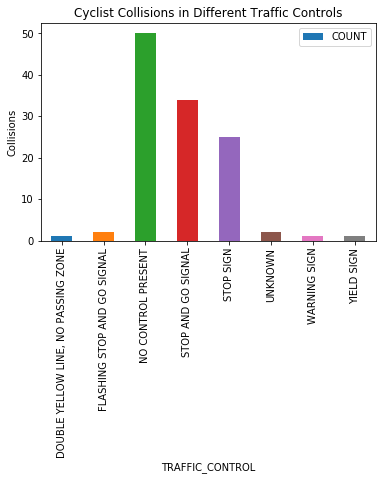

In [67]:
df3[df3.BIPED == 'B'].plot.bar(x='TRAFFIC_CONTROL', y='COUNT')
plt.title('Cyclist Collisions in Different Traffic Controls')
plt.ylabel('Collisions')

Text(0,0.5,'Collisions')

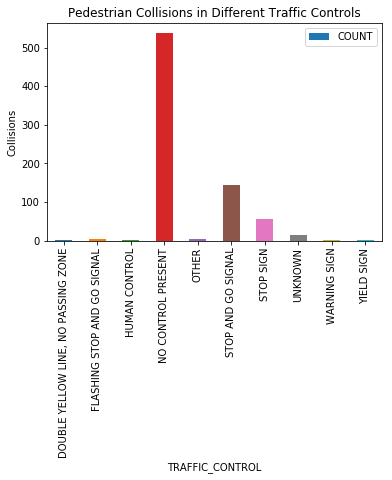

In [68]:
df3[df3.BIPED == 'P'].plot.bar(x='TRAFFIC_CONTROL', y='COUNT')
plt.title('Pedestrian Collisions in Different Traffic Controls')
plt.ylabel('Collisions')

Text(0,0.5,'Collisions')

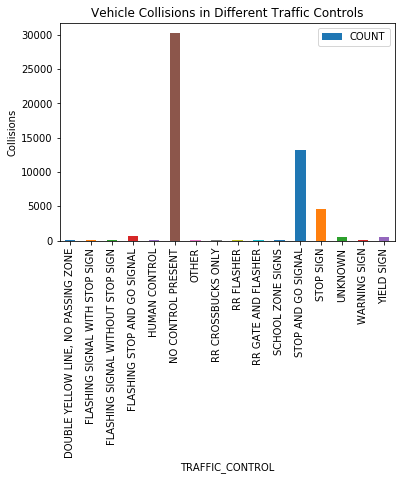

In [69]:
df3[df3.BIPED == 'M'].plot.bar(x='TRAFFIC_CONTROL', y='COUNT')
plt.title('Vehicle Collisions in Different Traffic Controls')
plt.ylabel('Collisions')

In [70]:
df31 = df3[df3['TRAFFIC_CONTROL'].isin(['DOUBLE YELLOW LINE, NO PASSING ZONE', 'FLASHING STOP AND GO SIGNAL', 
                                        'NO CONTROL PRESENT', 'STOP AND GO SIGNAL', 'STOP SIGN', 'UNKNOWN',
                                        'WARNING SIGN', 'YIELD SIGN'])]
df31_p = df31.pivot(index='BIPED', columns='TRAFFIC_CONTROL')
stats.chi2_contingency(df31_p)

(79.69101363974862,
 3.228577457085373e-11,
 14,
 array([[2.23845624e-01, 1.48012208e+00, 7.03560500e+01, 3.05298021e+01,
         1.06806340e+01, 1.20374126e+00, 1.91867677e-01, 1.33393719e+00],
        [9.63153687e+01, 6.36860805e+02, 3.02725101e+04, 1.31362369e+04,
         4.59561902e+03, 5.17940809e+02, 8.25560303e+01, 5.73960973e+02],
        [1.46078567e+00, 9.65907256e+00, 4.59133878e+02, 1.99233278e+02,
         6.97003446e+01, 7.85544944e+00, 1.25210200e+00, 8.70509009e+00]]))

#### Distribution

In [71]:
all_data.OBJECTID.isnull().sum()

0

In [72]:
ds = all_data.groupby(['BIPED','DATE']).DATE.count().to_frame(name='COUNT').reset_index()
ds

     BIPED        DATE  COUNT
0        B  2014-01-20      1
1        B  2014-02-27      1
2        B  2014-05-06      1
3        B  2014-05-11      1
4        B  2014-05-31      1
5        B  2014-06-02      1
6        B  2014-06-10      1
7        B  2014-06-20      3
8        B  2014-06-22      1
9        B  2014-07-03      1
...    ...         ...    ...
2497     P  2018-11-27      1
2498     P  2018-11-28      2
2499     P  2018-11-30      2
2500     P  2018-12-01      1
2501     P  2018-12-02      3
2502     P  2018-12-03      1
2503     P  2018-12-05      1
2504     P  2018-12-13      1
2505     P  2018-12-27      1
2506     P  2018-12-29      1

[2507 rows x 3 columns]

In [73]:
ds_1 = ds.groupby(['BIPED','COUNT']).COUNT.count().to_frame(name='FREQ').reset_index()
ds_1

   BIPED  COUNT  FREQ
0      B      1    99
1      B      2     7
2      B      3     1
3      M      1     5
4      M      6     1
5      M      7     3
6      M      8     5
7      M      9     1
8      M     10     7
9      M     11    13
..   ...    ...   ...
64     M     77     1
65     M     82     1
66     M     87     1
67     M     88     1
68     M     91     1
69     M    116     1
70     P      1   465
71     P      2   108
72     P      3    26
73     P      4     1

[74 rows x 3 columns]

In [74]:
lamB = ds[ds.BIPED=='B'].COUNT.mean()
lamP = ds[ds.BIPED=='P'].COUNT.mean()
lamM = ds[ds.BIPED=='M'].COUNT.mean()

print('Distribution for no. of Vehicle collisions per day is: Poisson(',lamM,')')
print('Distribution for no. of Pedestrian collisions per day is: Poisson(',lamP,')')
print('Distribution for no. of Cyclist collisions per day is: Poisson(',lamB,')')

Distribution for no. of Vehicle collisions per day is: Poisson( 27.90388888888889 )
Distribution for no. of Pedestrian collisions per day is: Poisson( 1.2716666666666667 )
Distribution for no. of Cyclist collisions per day is: Poisson( 1.0841121495327102 )


In [75]:
xP = ds_1[ds_1.BIPED=='P'].COUNT
xB = ds_1[ds_1.BIPED=='B'].COUNT
xM = ds_1[ds_1.BIPED=='M'].COUNT

In [76]:
totP = ds_1[ds_1.BIPED=='P'].FREQ.sum()
totM = ds_1[ds_1.BIPED=='M'].FREQ.sum()
totB = ds_1[ds_1.BIPED=='B'].FREQ.sum()

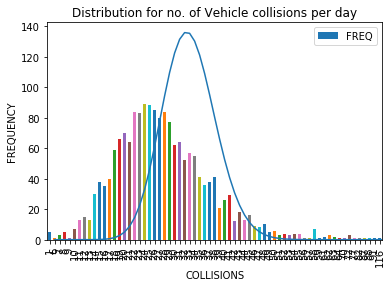

In [77]:
ds_1[ds_1.BIPED == 'M'].plot.bar(x='COUNT', y='FREQ')
plt.title('Distribution for no. of Vehicle collisions per day')
plt.ylabel('FREQUENCY')
plt.xlabel('COLLISIONS')
plt.plot(xM, poisson.pmf(xM, lamM)*(totM))

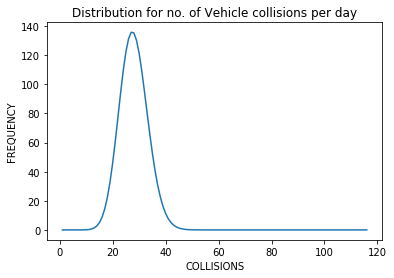

In [78]:
plt.plot(xM, poisson.pmf(xM, lamM)*(totM))
plt.title('Distribution for no. of Vehicle collisions per day')
plt.ylabel('FREQUENCY')
plt.xlabel('COLLISIONS')
plt.show()

In [79]:
ks_2samp(poisson.pmf(xM, lamM)*(totM), ds_1[ds_1.BIPED == 'M'].FREQ)

Ks_2sampResult(statistic=0.5074626865671642, pvalue=2.777077066188055e-08)

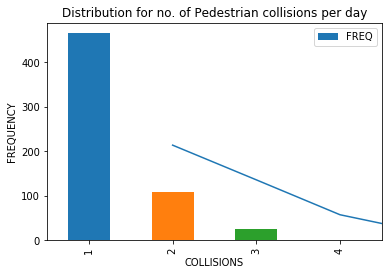

In [80]:
ds_1[ds_1.BIPED == 'P'].plot.bar(x='COUNT', y='FREQ')
plt.title('Distribution for no. of Pedestrian collisions per day')
plt.ylabel('FREQUENCY')
plt.xlabel('COLLISIONS')
plt.plot(xP, poisson.pmf(xP, lamP)*totP)

In [81]:
ks_2samp(poisson.pmf(xP, lamP)*(totP), ds_1[ds_1.BIPED == 'P'].FREQ)

Ks_2sampResult(statistic=0.25, pvalue=0.9968756885202118)

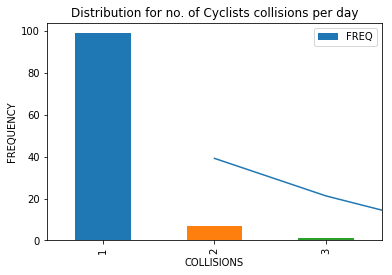

In [82]:
ds_1[ds_1.BIPED == 'B'].plot.bar(x='COUNT', y='FREQ')
plt.title('Distribution for no. of Cyclists collisions per day')
plt.ylabel('FREQUENCY')
plt.xlabel('COLLISIONS')
plt.plot(xB, poisson.pmf(xB, lamB)*totB)

In [83]:
ks_2samp(poisson.pmf(xM, lamB)*(totB), ds_1[ds_1.BIPED == 'B'].FREQ)

Ks_2sampResult(statistic=0.9850746268656716, pvalue=0.002107694691170252)

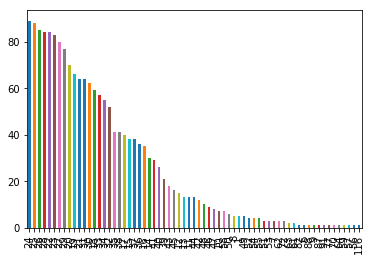

In [84]:
ds[ds.BIPED == 'M']['COUNT'].value_counts().plot(kind='bar')
#plt.show()
#ds['COUNT'].value_counts().plot(kind='bar')

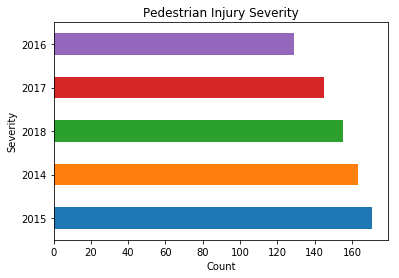

In [85]:
ped_data['YEAR'].value_counts().plot(kind='barh')
plt.title('Pedestrian Injury Severity')
plt.ylabel('Severity')
plt.xlabel('Count')
plt.show()

In [86]:
ped_data.ACCIDENT_YEAR.value_counts()

2015    171
2014    163
2018    155
2017    145
2016    129
Name: ACCIDENT_YEAR, dtype: int64

In [87]:
motor_data.ACCIDENT_YEAR.value_counts()

2018    11091
2017    10873
2016     9817
2015     9740
2014     8706
Name: ACCIDENT_YEAR, dtype: int64

In [88]:
ped_data.SEVERITY.value_counts()

C Type Injury (Possible)             431
B Type Injury (Evident)              166
B Type Injury (Suspected Minor)       55
A Type Injury (Disabling)             42
Fatal                                 35
O No Injury                           18
A Type Injury (Suspected Serious)     16
Name: SEVERITY, dtype: int64

In [89]:
motor_data.SEVERITY.value_counts()

O No Injury                          31312
C Type Injury (Possible)             15503
B Type Injury (Evident)               1807
UNKNOWN                                787
B Type Injury (Suspected Minor)        610
Fatal                                   86
A Type Injury (Disabling)               82
A Type Injury (Suspected Serious)       32
Fatality                                 8
Name: SEVERITY, dtype: int64

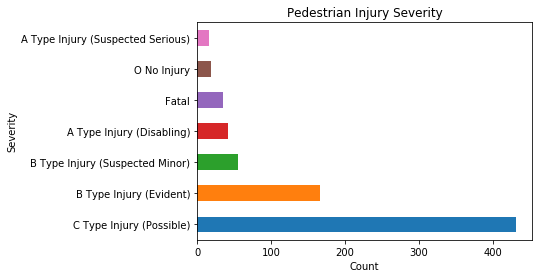

In [90]:
ped_data['SEVERITY'].value_counts().plot(kind='barh')
plt.title('Pedestrian Injury Severity')
plt.ylabel('Severity')
plt.xlabel('Count')
plt.show()

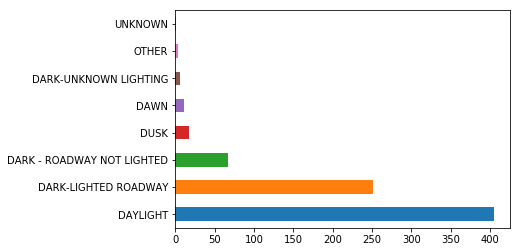

In [91]:
ped_data['LIGHT_CONDITIONS'].value_counts().plot(kind='barh')
plt.show()

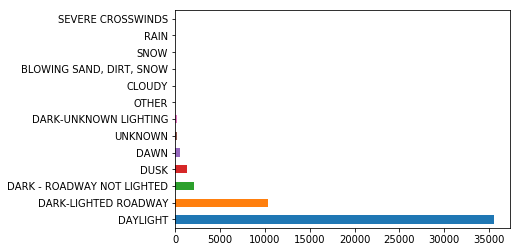

In [92]:
motor_data['LIGHT_CONDITIONS'].value_counts().plot(kind='barh')
plt.show()

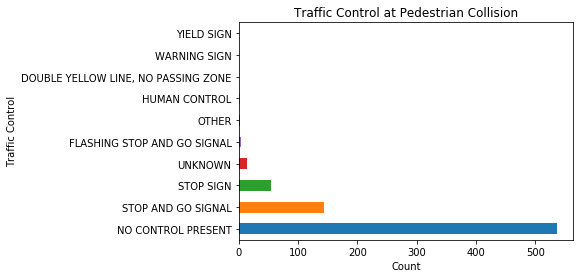

In [93]:
ped_data['TRAFFIC_CONTROL'].value_counts().plot(kind='barh')
plt.title('Traffic Control at Pedestrian Collision')
plt.ylabel('Traffic Control')
plt.xlabel('Count')
plt.show()

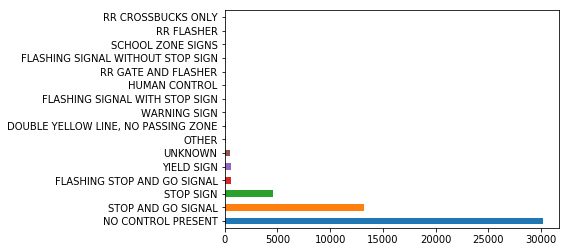

In [94]:
motor_data['TRAFFIC_CONTROL'].value_counts().plot(kind='barh')
plt.show()

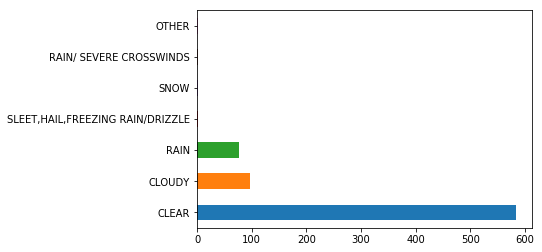

In [95]:
ped_data['WEATHER'].value_counts().plot(kind='barh')
plt.show()

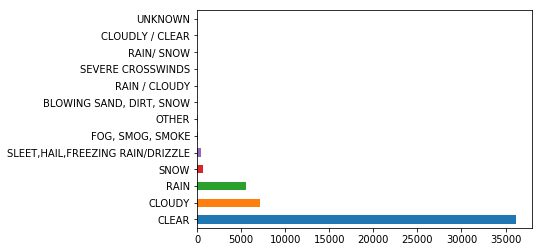

In [96]:
motor_data['WEATHER'].value_counts().plot(kind='barh')
plt.show()

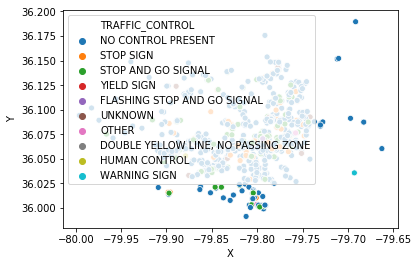

In [97]:
#sns.scatterplot(x="X", y="Y", hue="TRAFFIC_CONTROL", data=ped_data)
sns.scatterplot(x="X", y="Y", hue="TRAFFIC_CONTROL", data=ped_data)
plt.show()

### Spacial Clustering

Using DBSCAN unsupervised method to cluster pedestrian collisions

In [98]:
ped_data.head()
ped_data.shape


(763, 33)

In [99]:
#cord_data = ped_data[['X','Y']].copy()
cord_data = ped_data.as_matrix(columns=['X', 'Y'])
cord_data.shape

C:\Users\dimit\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


(763, 2)

In [100]:
meters_per_radian = 6371008.8
epsilon = 25 / meters_per_radian
db = DBSCAN(eps=epsilon, min_samples=1, algorithm='ball_tree', metric='haversine').fit(np.radians(cord_data))
cluster_labels = db.labels_
num_clusters = len(set(cluster_labels))
clusters = pd.Series([cord_data[cluster_labels == n ] for n in range(num_clusters)])
print('Number of clusters: {}'.format(num_clusters))

Number of clusters: 631


In [101]:
cord_data

array([[-79.85329663,  36.03868546],
       [-79.86303421,  36.03625717],
       [-79.7587672 ,  36.0679255 ],
       ...,
       [-79.78525087,  36.08779902],
       [-79.76553774,  36.09334285],
       [-79.76548041,  36.09608916]])

In [102]:
clusters

0      [[-79.8532966262646, 36.0386854648295], [-79.8...
1      [[-79.8630342076376, 36.0362571746119], [-79.8...
2                [[-79.7587671990725, 36.0679254978303]]
3                [[-79.8050769141391, 36.0147972057246]]
4                [[-79.8676188459283, 36.0686384027757]]
5                [[-79.8740043853782, 36.1176163301508]]
6                [[-79.7541487032787, 36.0633221370073]]
7                [[-79.7852139190406, 36.0610834857637]]
8                [[-79.8724524496051, 36.0601134960721]]
9                [[-79.8192298301179, 36.0230152758304]]
                             ...                        
621              [[-79.8697103170475, 36.0487923371076]]
622              [[-79.9118821134378, 36.0641198201648]]
623              [[-79.8702531572956, 36.0692844945084]]
624              [[-79.9052187115958, 36.0850444730073]]
625              [[-79.8062204093087, 36.0525802573319]]
626              [[-79.8075122594508, 36.0832456617728]]
627              [[-79.75718476

In [103]:
clusters.shape

(631,)

In [104]:
def get_centermost_point(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)

In [105]:
#centroid = (MultiPoint(clusters['X']).centroid.x, MultiPoint(clusters['Y']).centroid.y)

In [106]:
centermost_points = clusters.map(get_centermost_point)

In [107]:
centermost_points

0      (-79.8532966262646, 36.0386854648295)
1      (-79.8630342076376, 36.0362571746119)
2      (-79.7587671990725, 36.0679254978303)
3      (-79.8050769141391, 36.0147972057246)
4      (-79.8676188459283, 36.0686384027757)
5      (-79.8740043853782, 36.1176163301508)
6      (-79.7541487032787, 36.0633221370073)
7      (-79.7852139190406, 36.0610834857637)
8      (-79.8724524496051, 36.0601134960721)
9      (-79.8192298301179, 36.0230152758304)
                       ...                  
621    (-79.8697103170475, 36.0487923371076)
622    (-79.9118821134378, 36.0641198201648)
623    (-79.8702531572956, 36.0692844945084)
624    (-79.9052187115958, 36.0850444730073)
625    (-79.8062204093087, 36.0525802573319)
626    (-79.8075122594508, 36.0832456617728)
627    (-79.7571847645972, 36.0669661112781)
628    (-79.7811231268823, 36.0648225157376)
629    (-79.7655377375885, 36.0933428537608)
630     (-79.7654804062088, 36.096089156886)
Length: 631, dtype: object

In [108]:
X, Y = zip(*centermost_points)
rep_points = pd.DataFrame({'X':X, 'Y':Y})

In [109]:
rep_points

             X          Y
0   -79.853297  36.038685
1   -79.863034  36.036257
2   -79.758767  36.067925
3   -79.805077  36.014797
4   -79.867619  36.068638
5   -79.874004  36.117616
6   -79.754149  36.063322
7   -79.785214  36.061083
8   -79.872452  36.060113
9   -79.819230  36.023015
..         ...        ...
621 -79.869710  36.048792
622 -79.911882  36.064120
623 -79.870253  36.069284
624 -79.905219  36.085044
625 -79.806220  36.052580
626 -79.807512  36.083246
627 -79.757185  36.066966
628 -79.781123  36.064823
629 -79.765538  36.093343
630 -79.765480  36.096089

[631 rows x 2 columns]

In [110]:
#rs = rep_points.apply(lambda row: ped_data[(ped_data['X']==row['X']) & (ped_data['Y']==row['Y'])].iloc[0], axis=1)

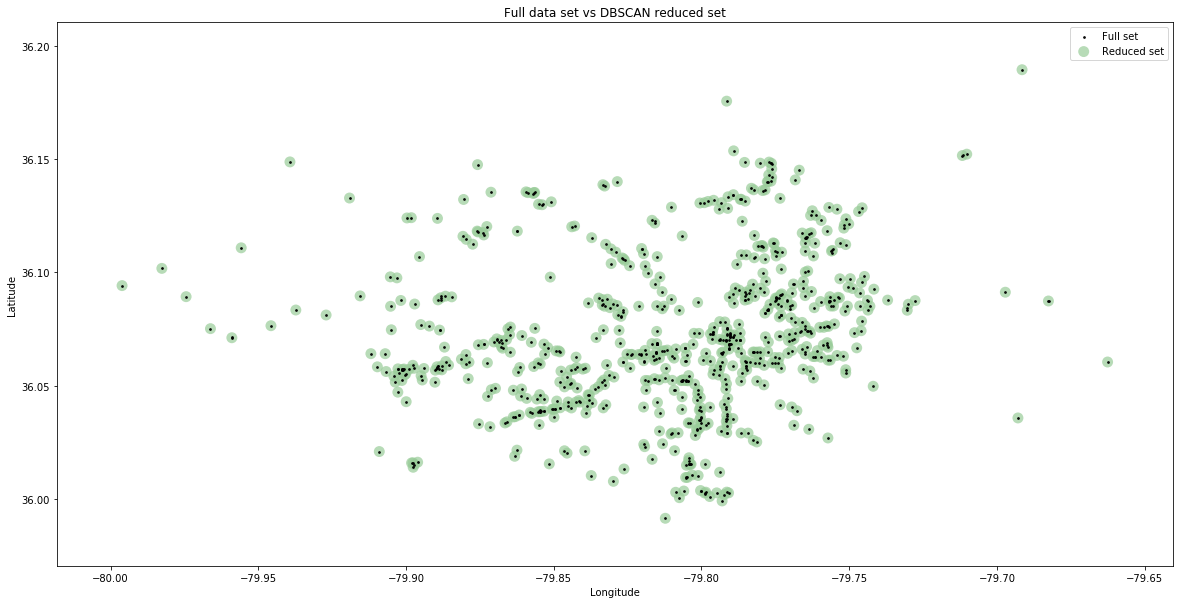

In [111]:
fig, ax = plt.subplots(figsize=[20, 10])
rs_scatter = ax.scatter(rep_points['X'], rep_points['Y'], c='#99cc99', edgecolor='None', alpha=0.7, s=120)
df_scatter = ax.scatter(ped_data['X'], ped_data['Y'], c='k', alpha=0.9, s=3)
ax.set_title('Full data set vs DBSCAN reduced set')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend([df_scatter, rs_scatter], ['Full set', 'Reduced set'], loc='upper right')
plt.show()

In [112]:
cords = ped_data[['X','Y']]
db = DBSCAN(eps=25/6371008.8, min_samples=1, algorithm='ball_tree', metric='haversine').fit(np.radians(cords))
ped_data['Cluster'] = db.labels_
ped_data

C:\Users\dimit\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


       OBJECTID                              ADDRESS  \
46        28991        HIGH POINT RD / BOULEVARD WAY   
137       29080           HIGH POINT RD / ROMAINE ST   
142       29085                      2101 SPENCER ST   
158       29100         RANDLEMAN RD / W VANDALIA RD   
649       29551  4653 W MARKET ST / SPRING GARDEN ST   
743       28391       NEW GARDEN RD / WILL DOSKEY DR   
780       28428                MOODY ST / DOUGLAS ST   
783       28431  MARTIN LUTHER KING JR DR / BROAD AV   
810       28458                   3701 W WENDOVER AV   
875       28522        TOLAR DR / REHOBETH CHURCH RD   
...         ...                                  ...   
51968    100134               W MARKET ST/NORWALK ST   
51969    100135                     601 FRIENDWAY RD   
51970    100136         FREEMAN MILL RD/W FLORIDA ST   
51971    100137               SEMINOLE DR/WHILDEN PL   
51973    100139               AVALON RD/S ENGLISH ST   
51976    100149             1098 US 29 N/E MARKE

In [113]:
ped_data['Cluster'].value_counts()

24     8
36     6
19     6
223    5
16     5
232    4
63     4
262    4
22     4
178    4
      ..
424    1
423    1
422    1
421    1
420    1
419    1
418    1
417    1
416    1
315    1
Name: Cluster, Length: 631, dtype: int64

### Supervised Learning

#### Random Forest - Severity

In [114]:
import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

In [115]:
ped_data['WEATHER'].value_counts()

CLEAR                               584
CLOUDY                               97
RAIN                                 77
SLEET,HAIL,FREEZING RAIN/DRIZZLE      2
SNOW                                  1
RAIN/ SEVERE CROSSWINDS               1
OTHER                                 1
Name: WEATHER, dtype: int64

In [116]:
ped_data['WEATHER_e'] = np.where(ped_data.WEATHER == 'CLEAR', 1,
                                np.where(ped_data.WEATHER == 'CLOUDY', 2,
                                        np.where(ped_data.WEATHER == 'RAIN', 3, 4)))
ped_data['WEATHER_e'].value_counts()

C:\Users\dimit\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


1    584
2     97
3     77
4      5
Name: WEATHER_e, dtype: int64

In [117]:
ped_data['LIGHT_CONDITIONS'].value_counts()

DAYLIGHT                      405
DARK-LIGHTED ROADWAY          251
DARK - ROADWAY NOT LIGHTED     67
DUSK                           18
DAWN                           11
DARK-UNKNOWN LIGHTING           6
OTHER                           4
UNKNOWN                         1
Name: LIGHT_CONDITIONS, dtype: int64

In [118]:
ped_data['LIGHT_CONDITIONS_e'] = np.where(ped_data.LIGHT_CONDITIONS == 'DAYLIGHT', 1,
                                          np.where(ped_data.LIGHT_CONDITIONS == 'DARK-LIGHTED ROADWAY', 2,
                                                   np.where(ped_data.LIGHT_CONDITIONS == 'DARK - ROADWAY NOT LIGHTED', 3,
                                                            np.where(ped_data.LIGHT_CONDITIONS == 'DUSK', 4,
                                                                     np.where(ped_data.LIGHT_CONDITIONS == 'DAWN', 5, 6)))))
ped_data['LIGHT_CONDITIONS_e'].value_counts()

C:\Users\dimit\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


1    405
2    251
3     67
4     18
6     11
5     11
Name: LIGHT_CONDITIONS_e, dtype: int64

In [119]:
ped_data['TRAFFIC_CONTROL'].value_counts()

NO CONTROL PRESENT                     537
STOP AND GO SIGNAL                     144
STOP SIGN                               55
UNKNOWN                                 14
FLASHING STOP AND GO SIGNAL              4
OTHER                                    3
HUMAN CONTROL                            2
DOUBLE YELLOW LINE, NO PASSING ZONE      1
WARNING SIGN                             1
YIELD SIGN                               1
Name: TRAFFIC_CONTROL, dtype: int64

In [120]:
ped_data['TRAFFIC_CONTROL_e'] = np.where(ped_data.TRAFFIC_CONTROL == 'NO CONTROL PRESENT', 1,
                                         np.where(ped_data.TRAFFIC_CONTROL == 'STOP AND GO SIGNAL', 2,
                                                  np.where(ped_data.TRAFFIC_CONTROL == 'STOP SIGN', 3,
                                                           np.where(ped_data.TRAFFIC_CONTROL == 'FLASHING STOP AND GO SIGNAL', 4, 5))))
ped_data['TRAFFIC_CONTROL_e'].value_counts()

C:\Users\dimit\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


1    537
2    144
3     55
5     23
4      4
Name: TRAFFIC_CONTROL_e, dtype: int64

In [121]:
ped_data['DAY'].value_counts()

Wednesday    124
Thursday     120
Friday       115
Tuesday      113
Monday       102
Saturday     101
Sunday        88
Name: DAY, dtype: int64

In [122]:
ped_data['DAY_e'] = np.where(ped_data.DAY == 'Monday', 1,
                             np.where(ped_data.DAY == 'Tuesday', 2,
                                      np.where(ped_data.DAY == 'Wednesday', 3,
                                               np.where(ped_data.DAY == 'Thursday', 4,
                                                        np.where(ped_data.DAY == 'Friday', 5,
                                                                 np.where(ped_data.DAY == 'Saturday', 6, 7))))))
ped_data['DAY_e'].value_counts()

C:\Users\dimit\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


3    124
4    120
5    115
2    113
1    102
6    101
7     88
Name: DAY_e, dtype: int64

In [123]:
ped_data['DAY_TIME'].value_counts()

Day           195
Night         186
Evening       150
Late Night    142
Morning        90
Name: DAY_TIME, dtype: int64

In [124]:
ped_data['DAY_TIME_e'] = np.where(ped_data.DAY_TIME == 'Morning', 1,
                                  np.where(ped_data.DAY_TIME == 'Day', 2,
                                           np.where(ped_data.DAY_TIME == 'Evening', 3,
                                                    np.where(ped_data.DAY_TIME == 'Night', 4,5))))
ped_data['DAY_TIME_e'].value_counts()

C:\Users\dimit\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


2    195
4    186
3    150
5    142
1     90
Name: DAY_TIME_e, dtype: int64

In [125]:
X_rf = ped_data[['WEATHER_e', 'LIGHT_CONDITIONS_e', 'TRAFFIC_CONTROL_e', 'DAY_e', 'DAY_TIME_e', 'Cluster']]
Y_rf = ped_data['SEVERITY_CD']

In [126]:
X_rf_train, X_rf_test, Y_rf_train, Y_rf_test = train_test_split(X_rf, Y_rf, test_size=0.2)

In [127]:
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_rf_train,Y_rf_train)
Y_rf_pred=clf.predict(X_rf_test)
print("Accuracy:",metrics.accuracy_score(Y_rf_test, Y_rf_pred))

Accuracy: 0.5032679738562091


Text(0,0.5,'true label')

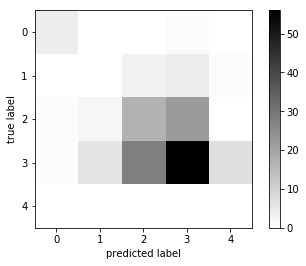

In [128]:
plt.imshow(metrics.confusion_matrix(Y_rf_pred, Y_rf_test),
           interpolation='nearest', cmap=plt.cm.binary)
plt.grid(False)
plt.colorbar()
plt.xlabel("predicted label")
plt.ylabel("true label")

In [129]:
print (metrics.classification_report(Y_rf_pred, Y_rf_test))

              precision    recall  f1-score   support

           1       0.67      0.80      0.73         5
           2       0.00      0.00      0.00         8
           3       0.35      0.40      0.38        42
           4       0.67      0.57      0.62        98
           5       0.00      0.00      0.00         0

   micro avg       0.50      0.50      0.50       153
   macro avg       0.34      0.36      0.34       153
weighted avg       0.55      0.50      0.52       153



C:\Users\dimit\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\dimit\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\dimit\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [130]:
feature_names = ['WEATHER_e', 'LIGHT_CONDITIONS_e', 'TRAFFIC_CONTROL_e', 'DAY_e', 'DAY_TIME_e', 'Cluster']
feature_names


['WEATHER_e',
 'LIGHT_CONDITIONS_e',
 'TRAFFIC_CONTROL_e',
 'DAY_e',
 'DAY_TIME_e',
 'Cluster']

In [131]:
feature_imp = pd.Series(clf.feature_importances_,index=feature_names).sort_values(ascending=False)
feature_imp

Cluster               0.559671
DAY_e                 0.160090
DAY_TIME_e            0.098319
LIGHT_CONDITIONS_e    0.065084
TRAFFIC_CONTROL_e     0.060110
WEATHER_e             0.056726
dtype: float64

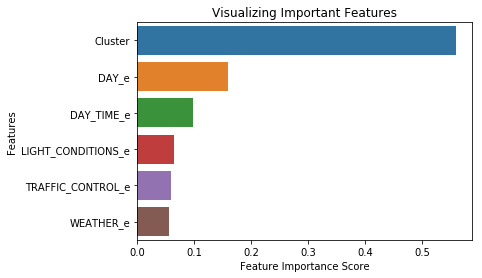

In [132]:
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

In [133]:
X_rf = ped_data[[ 'DAY_e', 'DAY_TIME_e', 'Cluster']]
Y_rf = ped_data['SEVERITY_CD']
X_rf_train, X_rf_test, Y_rf_train, Y_rf_test = train_test_split(X_rf, Y_rf, test_size=0.3)
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_rf_train,Y_rf_train)
Y_rf_pred=clf.predict(X_rf_test)
print("Accuracy:",metrics.accuracy_score(Y_rf_test, Y_rf_pred))

Accuracy: 0.4759825327510917


Text(0,0.5,'true label')

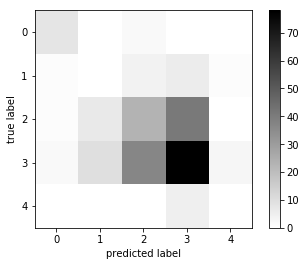

In [134]:
plt.imshow(metrics.confusion_matrix(Y_rf_pred, Y_rf_test),
           interpolation='nearest', cmap=plt.cm.binary)
plt.grid(False)
plt.colorbar()
plt.xlabel("predicted label")
plt.ylabel("true label")

In [135]:
feature_names = ['DAY_e', 'DAY_TIME_e', 'Cluster']
feature_imp = pd.Series(clf.feature_importances_,index=feature_names).sort_values(ascending=False)
feature_imp

Cluster       0.820049
DAY_e         0.105138
DAY_TIME_e    0.074813
dtype: float64

#### Random Forest - Accident Count

In [136]:
ped_data.head()

     OBJECTID                              ADDRESS  \
46      28991        HIGH POINT RD / BOULEVARD WAY   
137     29080           HIGH POINT RD / ROMAINE ST   
142     29085                      2101 SPENCER ST   
158     29100         RANDLEMAN RD / W VANDALIA RD   
649     29551  4653 W MARKET ST / SPRING GARDEN ST   

                    ACCIDENT_CAUSE COLLISION_DESC WEATHER  \
46         FAIL TO YIELD RIGHTAWAY     PEDESTRIAN   CLEAR   
137  NO CONTRIBUTING CIRCUMSTANCES     PEDESTRIAN   CLEAR   
142                       OTHER*\r     PEDESTRIAN   CLEAR   
158  NO CONTRIBUTING CIRCUMSTANCES     PEDESTRIAN   CLEAR   
649        FAIL TO YIELD RIGHTAWAY     PEDESTRIAN  CLOUDY   

         LIGHT_CONDITIONS            ROAD_CLASS     TRAFFIC_CONTROL  \
46               DAYLIGHT  PUBLIC VEHICULAR WAY  NO CONTROL PRESENT   
137  DARK-LIGHTED ROADWAY                 LOCAL  NO CONTROL PRESENT   
142  DARK-LIGHTED ROADWAY  PUBLIC VEHICULAR WAY  NO CONTROL PRESENT   
158              DAYLIGH

In [137]:
ped_data['Cluster_units'] = ped_data.groupby('Cluster')['Cluster'].transform('count')


C:\Users\dimit\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [138]:
X_rf_ct = ped_data[['WEATHER_e', 'LIGHT_CONDITIONS_e', 'TRAFFIC_CONTROL_e', 'DAY_e', 'DAY_TIME_e', 'Cluster']]
Y_rf_ct = ped_data['Cluster_units']
X_rf_ct_train, X_rf_ct_test, Y_rf_ct_train, Y_rf_ct_test = train_test_split(X_rf_ct, Y_rf_ct, test_size=0.3)
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_rf_ct_train,Y_rf_ct_train)
Y_rf_ct_pred=clf.predict(X_rf_ct_test)
print("Accuracy:",metrics.accuracy_score(Y_rf_ct_test, Y_rf_ct_pred))

Accuracy: 0.6855895196506551


Text(0,0.5,'true label')

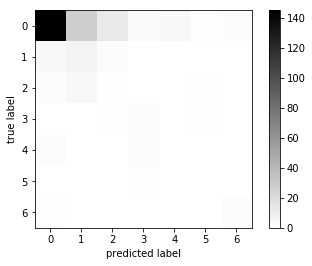

In [139]:
plt.imshow(metrics.confusion_matrix(Y_rf_ct_pred, Y_rf_ct_test),
           interpolation='nearest', cmap=plt.cm.binary)
plt.grid(False)
plt.colorbar()
plt.xlabel("predicted label")
plt.ylabel("true label")

In [140]:
print (metrics.classification_report(Y_rf_ct_pred, Y_rf_ct_test))

              precision    recall  f1-score   support

           1       0.94      0.74      0.83       196
           2       0.18      0.54      0.27        13
           3       0.06      0.12      0.08         8
           4       0.25      0.50      0.33         4
           5       0.00      0.00      0.00         4
           6       0.00      0.00      0.00         1
           8       0.50      0.67      0.57         3

   micro avg       0.69      0.69      0.69       229
   macro avg       0.28      0.37      0.30       229
weighted avg       0.83      0.69      0.74       229



In [141]:
feature_names = ['WEATHER_e', 'LIGHT_CONDITIONS_e', 'TRAFFIC_CONTROL_e', 'DAY_e', 'DAY_TIME_e', 'Cluster']
feature_imp = pd.Series(clf.feature_importances_,index=feature_names).sort_values(ascending=False)
feature_imp

Cluster               0.541351
DAY_e                 0.150302
DAY_TIME_e            0.108837
TRAFFIC_CONTROL_e     0.070525
LIGHT_CONDITIONS_e    0.068542
WEATHER_e             0.060443
dtype: float64

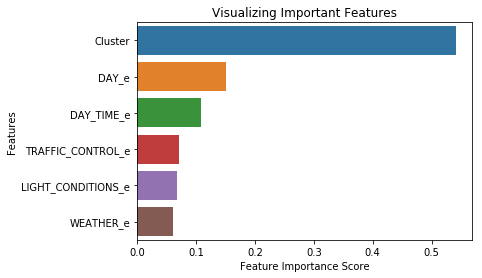

In [142]:
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

In [143]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

In [144]:
X_rf_ct = ped_data[['WEATHER_e', 'LIGHT_CONDITIONS_e', 'TRAFFIC_CONTROL_e', 'DAY_e', 'DAY_TIME_e', 'Cluster']]
Y_rf_ct = ped_data['Cluster_units']
X_rf_ct_train, X_rf_ct_test, Y_rf_ct_train, Y_rf_ct_test = train_test_split(X_rf_ct, Y_rf_ct, test_size=0.3)

sc = StandardScaler()
X_rf_ct_train = sc.fit_transform(X_rf_ct_train)
X_rf_ct_test = sc.transform(X_rf_ct_test)

regressor = RandomForestRegressor(n_estimators=500)
regressor.fit(X_rf_ct_train,Y_rf_ct_train)
Y_rf_ct_pred=regressor.predict(X_rf_ct_test)

print('Mean Absolute Error:', metrics.mean_absolute_error(Y_rf_ct_test, Y_rf_ct_pred))
print('Mean Squared Error:', metrics.mean_squared_error(Y_rf_ct_test, Y_rf_ct_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_rf_ct_test, Y_rf_ct_pred)))
print('R-Squared:', metrics.r2_score(Y_rf_ct_test, Y_rf_ct_pred))

C:\Users\dimit\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int32, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\dimit\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int32, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\dimit\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype int32, int64 were all converted to float64 by StandardScaler.
  import sys


Mean Absolute Error: 0.43024454148471614
Mean Squared Error: 0.465105903930131
Root Mean Squared Error: 0.6819867329575635
R-Squared: 0.6313723255448418


In [145]:
feature_names = ['WEATHER_e', 'LIGHT_CONDITIONS_e', 'TRAFFIC_CONTROL_e', 'DAY_e', 'DAY_TIME_e', 'Cluster']
feature_imp = pd.Series(regressor.feature_importances_,index=feature_names).sort_values(ascending=False)
feature_imp

Cluster               0.772635
DAY_e                 0.088170
TRAFFIC_CONTROL_e     0.062482
DAY_TIME_e            0.040975
LIGHT_CONDITIONS_e    0.018016
WEATHER_e             0.017721
dtype: float64

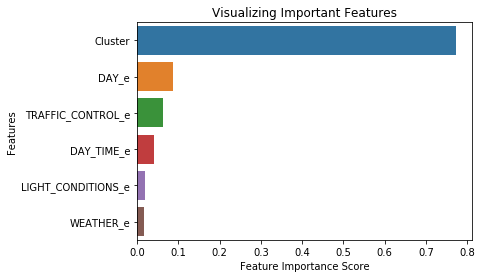

In [146]:
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

#### Random Forest without single clusters

In [147]:
ped_data_l_cl = ped_data.query('Cluster_units > 1').copy()

In [148]:
X_rf = ped_data_l_cl[['WEATHER_e', 'LIGHT_CONDITIONS_e', 'TRAFFIC_CONTROL_e', 'DAY_e', 'DAY_TIME_e', 'Cluster']]
Y_rf = ped_data_l_cl['SEVERITY_CD']
X_rf_train, X_rf_test, Y_rf_train, Y_rf_test = train_test_split(X_rf, Y_rf, test_size=0.3)
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_rf_train,Y_rf_train)
Y_rf_pred=clf.predict(X_rf_test)
print("Accuracy:",metrics.accuracy_score(Y_rf_test, Y_rf_pred))

Accuracy: 0.5757575757575758


Text(0,0.5,'true label')

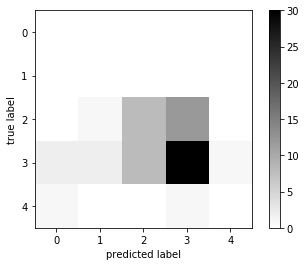

In [149]:
plt.imshow(metrics.confusion_matrix(Y_rf_pred, Y_rf_test),
           interpolation='nearest', cmap=plt.cm.binary)
plt.grid(False)
plt.colorbar()
plt.xlabel("predicted label")
plt.ylabel("true label")

In [150]:
print (metrics.classification_report(Y_rf_pred, Y_rf_test))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.50      0.38      0.43        21
           4       0.70      0.70      0.70        43
           5       0.00      0.00      0.00         2

   micro avg       0.58      0.58      0.58        66
   macro avg       0.24      0.22      0.23        66
weighted avg       0.61      0.58      0.59        66



C:\Users\dimit\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\dimit\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\dimit\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [151]:
feature_names = ['WEATHER_e', 'LIGHT_CONDITIONS_e', 'TRAFFIC_CONTROL_e', 'DAY_e', 'DAY_TIME_e', 'Cluster']
feature_imp = pd.Series(clf.feature_importances_,index=feature_names).sort_values(ascending=False)
feature_imp

Cluster               0.408770
DAY_e                 0.187840
DAY_TIME_e            0.136334
LIGHT_CONDITIONS_e    0.099467
TRAFFIC_CONTROL_e     0.092318
WEATHER_e             0.075271
dtype: float64

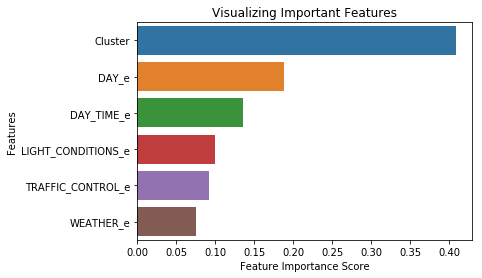

In [152]:
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

In [153]:
X_rf_ct = ped_data_l_cl[['WEATHER_e', 'LIGHT_CONDITIONS_e', 'TRAFFIC_CONTROL_e', 'DAY_e', 'DAY_TIME_e', 'Cluster']]
Y_rf_ct = ped_data_l_cl['Cluster_units']
X_rf_ct_train, X_rf_ct_test, Y_rf_ct_train, Y_rf_ct_test = train_test_split(X_rf_ct, Y_rf_ct, test_size=0.3)

sc = StandardScaler()
X_rf_ct_train = sc.fit_transform(X_rf_ct_train)
X_rf_ct_test = sc.transform(X_rf_ct_test)

regressor = RandomForestRegressor(n_estimators=500)
regressor.fit(X_rf_ct_train,Y_rf_ct_train)
Y_rf_ct_pred=regressor.predict(X_rf_ct_test)

print('Mean Absolute Error:', metrics.mean_absolute_error(Y_rf_ct_test, Y_rf_ct_pred))
print('Mean Squared Error:', metrics.mean_squared_error(Y_rf_ct_test, Y_rf_ct_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_rf_ct_test, Y_rf_ct_pred)))
print('R-Squared:', metrics.r2_score(Y_rf_ct_test, Y_rf_ct_pred))

C:\Users\dimit\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int32, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\dimit\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int32, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\dimit\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype int32, int64 were all converted to float64 by StandardScaler.
  import sys


Mean Absolute Error: 0.566030303030303
Mean Squared Error: 0.5601531515151515
Root Mean Squared Error: 0.7484337990197607
R-Squared: 0.7447937320363979


In [154]:
feature_names = ['WEATHER_e', 'LIGHT_CONDITIONS_e', 'TRAFFIC_CONTROL_e', 'DAY_e', 'DAY_TIME_e', 'Cluster']
feature_imp = pd.Series(regressor.feature_importances_,index=feature_names).sort_values(ascending=False)
feature_imp

Cluster               0.791288
DAY_TIME_e            0.057608
DAY_e                 0.050623
TRAFFIC_CONTROL_e     0.034844
WEATHER_e             0.034478
LIGHT_CONDITIONS_e    0.031159
dtype: float64

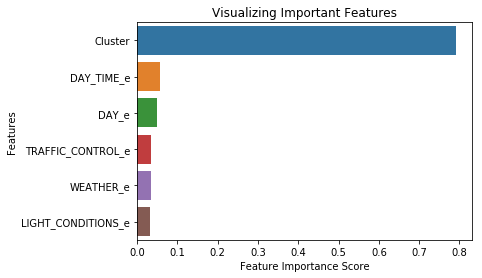

In [155]:
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

In [156]:
ped_data_l_cl2 = ped_data.query('Cluster_units > 5')

ped_data_l_cl2.shape

(20, 40)

#### RF with Standardizing Clusters

stndardizing clusters using the z-score of cluster units column

In [157]:
Cluster_units = pd.DataFrame(ped_data, columns = ['Cluster_units'])
ped_data['z_Cluster_units'] = Cluster_units.apply(stats.zscore)

ped_data.loc[(ped_data['z_Cluster_units'] < -1), 'Cluster_units_Group'] = 'Low'
ped_data.loc[(ped_data['z_Cluster_units'] >= -1) & (ped_data['z_Cluster_units'] <= 1), 'Cluster_units_Group'] = 'Normal'
ped_data.loc[(ped_data['z_Cluster_units'] > 1), 'Cluster_units_Group'] = 'High'

C:\Users\dimit\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\dimit\Anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\dimit\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas

Encoding the new column

In [158]:
ped_data['Cluster_units_Group_e'] = np.where(ped_data.Cluster_units_Group == 'Low', 1,
                                  np.where(ped_data.Cluster_units_Group == 'Normal', 2, 3))
ped_data['Cluster_units_Group_e'].value_counts()

C:\Users\dimit\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


2    662
3    101
Name: Cluster_units_Group_e, dtype: int64

Running the random forest classification model for severity

In [233]:
X_rf_ct = ped_data[['WEATHER_e', 'LIGHT_CONDITIONS_e', 'TRAFFIC_CONTROL_e', 'DAY_e', 'DAY_TIME_e', 'Cluster_units_Group_e']]
Y_rf_ct = ped_data['SEVERITY_CD']
X_rf_ct_train, X_rf_ct_test, Y_rf_ct_train, Y_rf_ct_test = train_test_split(X_rf_ct, Y_rf_ct, test_size=0.3)
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_rf_ct_train,Y_rf_ct_train)
Y_rf_ct_pred=clf.predict(X_rf_ct_test)
print("Accuracy:",metrics.accuracy_score(Y_rf_ct_test, Y_rf_ct_pred))

Accuracy: 0.48034934497816595


Text(0.5,1,'Confusion Matrix')

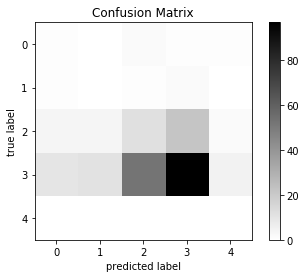

In [234]:
plt.imshow(metrics.confusion_matrix(Y_rf_ct_pred, Y_rf_ct_test),
           interpolation='nearest', cmap=plt.cm.binary)
plt.grid(False)
plt.colorbar()
plt.xlabel("predicted label")
plt.ylabel("true label")
plt.title("Confusion Matrix")

In [238]:
print (metrics.classification_report(Y_rf_ct_pred, Y_rf_ct_test))

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.


              precision    recall  f1-score   support

           1       0.06      0.20      0.10         5
           2       0.00      0.00      0.00         4
           3       0.18      0.27      0.21        44
           4       0.80      0.55      0.65       176
           5       0.00      0.00      0.00         0

   micro avg       0.48      0.48      0.48       229
   macro avg       0.21      0.20      0.19       229
weighted avg       0.65      0.48      0.54       229



In [239]:
feature_names = ['WEATHER_e', 'LIGHT_CONDITIONS_e', 'TRAFFIC_CONTROL_e', 'DAY_e', 'DAY_TIME_e', 'Cluster_units_Group_e']
feature_imp = pd.Series(clf.feature_importances_,index=feature_names).sort_values(ascending=False)
feature_imp

DAY_e                    0.325350
DAY_TIME_e               0.221750
LIGHT_CONDITIONS_e       0.143851
TRAFFIC_CONTROL_e        0.138830
WEATHER_e                0.119245
Cluster_units_Group_e    0.050974
dtype: float64

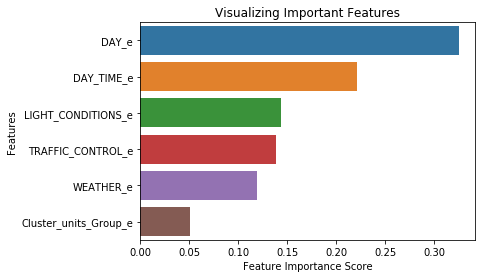

In [240]:
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

Running the random forest regression model for cluster units

In [282]:
X_rf_ct = ped_data[['WEATHER_e', 'LIGHT_CONDITIONS_e', 'TRAFFIC_CONTROL_e', 'DAY_e', 'DAY_TIME_e', 'Cluster_units_Group_e']]
Y_rf_ct = ped_data['Cluster_units']
X_rf_ct_train, X_rf_ct_test, Y_rf_ct_train, Y_rf_ct_test = train_test_split(X_rf_ct, Y_rf_ct, test_size=0.3)

#sc = StandardScaler()
#X_rf_ct_train = sc.fit_transform(X_rf_ct_train)
#X_rf_ct_test = sc.transform(X_rf_ct_test)

regressor = RandomForestRegressor(n_estimators=500)
regressor.fit(X_rf_ct_train,Y_rf_ct_train)
Y_rf_ct_pred=regressor.predict(X_rf_ct_test)

print('Mean Absolute Error:', metrics.mean_absolute_error(Y_rf_ct_test, Y_rf_ct_pred))
print('Mean Squared Error:', metrics.mean_squared_error(Y_rf_ct_test, Y_rf_ct_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_rf_ct_test, Y_rf_ct_pred)))
print('R-Squared:', metrics.r2_score(Y_rf_ct_test, Y_rf_ct_pred))

Mean Absolute Error: 0.45799062504240934
Mean Squared Error: 0.5653914576191719
Root Mean Squared Error: 0.7519251675660098
R-Squared: 0.698718718967128


In [283]:
feature_names = ['WEATHER_e', 'LIGHT_CONDITIONS_e', 'TRAFFIC_CONTROL_e', 'DAY_e', 'DAY_TIME_e', 'Cluster_units_Group_e']
feature_imp = pd.Series(regressor.feature_importances_,index=feature_names).sort_values(ascending=False)
feature_imp

Cluster_units_Group_e    0.753874
DAY_e                    0.074310
DAY_TIME_e               0.065031
TRAFFIC_CONTROL_e        0.037214
LIGHT_CONDITIONS_e       0.036609
WEATHER_e                0.032963
dtype: float64

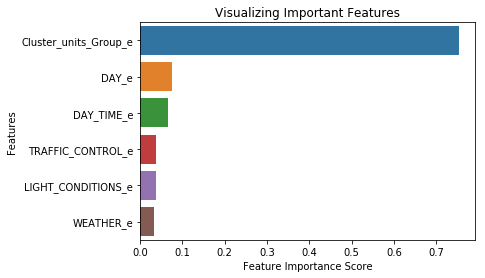

In [284]:
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

In [210]:
shap.initjs()

In [216]:
#explainer = shap.TreeExplainer(clf)
#shap_values = explainer.shap_values(X_rf_ct_train)
#i = 4776
#shap.force_plot(explainer.expected_value, shap_values[i], features=X_train.loc[4776], feature_names=X_train.columns)

Identify the clusters with high pedestrian collisions

In [286]:
ped_data.drop_duplicates(['Cluster'])[ped_data['Cluster_units'] >= 5].ADDRESS



Boolean Series key will be reindexed to match DataFrame index.


1613      4302 BIG TREE WAY / W WENDOVER AV
1751     4424 W WENDOVER AV / BRIDFORD PKWY
1971                S AYCOCK ST / WALKER AV
2283                 E MARKET ST / S ELM ST
14912                        3106 SUMMIT AV
Name: ADDRESS, dtype: object

In [294]:
ped_data[ped_data['SEVERITY_CD'] <= 2 ].DAY.value_counts()

Friday       16
Wednesday    15
Tuesday      14
Saturday     13
Thursday     12
Monday       12
Sunday       11
Name: DAY, dtype: int64

In [290]:
ped_data[ped_data['SEVERITY_CD'] <= 2].DAY_TIME.value_counts()

Night         34
Late Night    19
Day           18
Evening       14
Morning        8
Name: DAY_TIME, dtype: int64